<a href="https://colab.research.google.com/github/ranton256/cs583_final_project_classify/blob/main/cs583_final_project_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

In [2]:
!wget https://image-net.org/data/tiny-imagenet-200.zip
#training_loader = torch.utils.data.DateLoader()

--2021-05-26 01:55:34--  https://image-net.org/data/tiny-imagenet-200.zip
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  13.9MB/s    in 15s     

2021-05-26 01:55:50 (15.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
!unzip tiny-imagenet-200.zip


Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [4]:
!ls tiny-imagenet-200/

test  train  val  wnids.txt  words.txt


In [5]:
#  careful...
!rm -Rf cs583_final_project_classify
# git[sic] a fresh copy.
!git clone https://github.com/ranton256/cs583_final_project_classify.git

Cloning into 'cs583_final_project_classify'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 4), reused 18 (delta 2), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [6]:
!tail cs583_final_project_classify/make_subset.py

    else:
        original_data_dir = sys.argv[1]

    setup_training_data(original_data_dir)
    setup_validation_data(original_data_dir)
    setup_test_data()


if __name__ == "__main__":
    main()

In [7]:
from cs583_final_project_classify import make_subset

original_data_dir = "tiny-imagenet-200"

# This creates a subset of images that are either feline or canine.
make_subset.setup_training_data(original_data_dir)
make_subset.setup_validation_data(original_data_dir)
make_subset.setup_test_data()

Streaming output truncated to the last 5000 lines.
copy tiny-imagenet-200/train/n02129165/images/n02129165_117.JPEG to felines_and_canines/train/feline/n02129165_117.JPEG
copy tiny-imagenet-200/train/n02129165/images/n02129165_105.JPEG to felines_and_canines/train/feline/n02129165_105.JPEG
copy tiny-imagenet-200/train/n02129165/images/n02129165_41.JPEG to felines_and_canines/train/feline/n02129165_41.JPEG
copy tiny-imagenet-200/train/n02129165/images/n02129165_6.JPEG to felines_and_canines/train/feline/n02129165_6.JPEG
copy tiny-imagenet-200/train/n02129165/images/n02129165_19.JPEG to felines_and_canines/train/feline/n02129165_19.JPEG
copy tiny-imagenet-200/train/n02129165/images/n02129165_344.JPEG to felines_and_canines/train/feline/n02129165_344.JPEG
copy tiny-imagenet-200/train/n02129165/images/n02129165_483.JPEG to felines_and_canines/train/feline/n02129165_483.JPEG
copy tiny-imagenet-200/train/n02129165/images/n02129165_432.JPEG to felines_and_canines/train/feline/n02129165_432.JP

In [8]:
!ls felines_and_canines/

test  train  val


In [11]:
#imagenet_data = torchvision.datasets.ImageNet('tiny-imagenet-200/')


#data_loader = torch.utils.data.DataLoader(imagenet_data,
#                                          batch_size=4,
#                                          shuffle=True,
#                                          num_workers=args.nThreads)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # TODO: look this up, is this adjusting the mean?
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'felines_and_canines'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


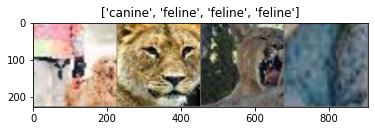

In [15]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

inputs, classes = inputs.to(device), classes.to(device)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out.cpu(), title=[class_names[x] for x in classes])

In [19]:
# TODO:  use my network model.
#model_ft = models.resnet18(True)

#model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
#model_ft.fc.out_features = 200
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model_ft = model_ft.to(device)

#Loss Function
#criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
# TODO: change to VGG 16
print("VGG")
# (classifier): Sequential(
#    (0): Linear(in_features=25088, out_features=4096, bias=True)
#    (1): ReLU(inplace=True)
#    (2): Dropout(p=0.5, inplace=False)
#    (3): Linear(in_features=4096, out_features=4096, bias=True)
#    (4): ReLU(inplace=True)
#    (5): Dropout(p=0.5, inplace=False)
#    (6): Linear(in_features=4096, out_features=1000, bias=True)
#  )
#model_ft = models.vgg16(pretrained=True)  #.features.to(device).eval()
#print(model_ft)

#model_ft = models.resnet18(pretrained=True)
#print("resnet")
#print(model_ft)

# (fc): Linear(in_features=512, out_features=1000, bias=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

#nn.Linear(num_ftrs, 2)
#my_fc = nn.Linear(num_ftrs, len(class_names))

#model_ft.fc = my_fc

#model_ft = model_ft.to(device)

# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn(pretrained=True)
#vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# freeze all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# replace classifier layers
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # strip last layer
features.extend([nn.Linear(num_features, len(class_names))]) ## new last layer
vgg16.classifier = nn.Sequential(*features) # replace classifier in model

print(vgg16)

# TODO: cleanup
model_ft = vgg16

criterion = nn.CrossEntropyLoss()

# hmm
if torch.cuda.is_available():
  model_ft = model_ft.cuda()
  criterion = criterion.cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)




VGG


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5795 Acc: 0.6978
val Loss: 0.3676 Acc: 0.8327

Epoch 1/24
----------
train Loss: 0.4958 Acc: 0.7505
val Loss: 0.3476 Acc: 0.8255

Epoch 2/24
----------
train Loss: 0.4592 Acc: 0.7752
val Loss: 0.3066 Acc: 0.8564

Epoch 3/24
----------
train Loss: 0.4392 Acc: 0.7808
val Loss: 0.2726 Acc: 0.8891

Epoch 4/24
----------
train Loss: 0.4093 Acc: 0.8071
val Loss: 0.2910 Acc: 0.8618

Epoch 5/24
----------
train Loss: 0.4074 Acc: 0.7994
val Loss: 0.2564 Acc: 0.8836

Epoch 6/24
----------
train Loss: 0.3845 Acc: 0.8105
val Loss: 0.2536 Acc: 0.8782

Epoch 7/24
----------
train Loss: 0.3305 Acc: 0.8467
val Loss: 0.2294 Acc: 0.8982

Epoch 8/24
----------
train Loss: 0.3010 Acc: 0.8556
val Loss: 0.2075 Acc: 0.8945

Epoch 9/24
----------
train Loss: 0.2935 Acc: 0.8614
val Loss: 0.2090 Acc: 0.9109

Epoch 10/24
----------
train Loss: 0.2862 Acc: 0.8655
val Loss: 0.2121 Acc: 0.9127

Epoch 11/24
----------
train Loss: 0.2700 Acc: 0.8762
val Loss: 0.2069 Acc: 0.9073

Ep

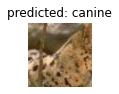

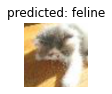

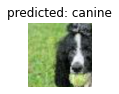

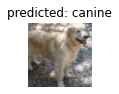

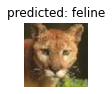

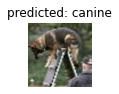

In [22]:
visualize_model(model_ft)

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
import os
model_save_name = input("Enter model filename") 
#'pretrained_classifier.pt'
model_save_name = model_save_name + '.pt'
path = os.path.join(F"/content/gdrive/My Drive/cs583_final_project_models/", model_save_name)
torch.save(model_ft.state_dict(), path)

Enter model filenamefirst_pretrained_classifier


In [29]:
!ls '/content/gdrive/My Drive/cs583_final_project_models'

first_pretrained_classifier.pt
